## Imports

In [12]:
!pip install pandas numpy matplotlib seaborn 
!pip install plotnine

In [13]:
#Import packages
import numpy as np
import pandas as pd
import os, re
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats.mstats import winsorize
from scipy.stats import bootstrap

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

## Data read


In [14]:
# Define path for folder with participant data
folder_path = '../data'

# Save all filenames in a list
tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]


## Defining variables, dataframes and list

In [15]:
# Define target coordinates
target_coords = [
    (-320, 0), (320, 0), (-277, -160), (277, 160), 
    (0, 320), (0, -320), (277, -160), (-277, 160), 
    (-160, -277), (160, 277), (160, -277), (-160, 277)
]
# Define target names according to the coordinates
target_names = [
    'nine', 'three', 'ten', 'four', 
    'six', 'twelve', 'two', 'eight', 
    'eleven', 'five', 'one', 'seven'
]
target_coord_to_name = dict(zip(target_coords, target_names))

# Ensure the dataframe is in the correct order from one to twelve
target_order = [
    'one', 'two', 'three', 'four', 
    'five', 'six', 'seven', 'eight', 
    'nine', 'ten', 'eleven', 'twelve'
]

# Save screen-dimensions and threshold to define whether a target was fixated or not
screen_width = 1920
screen_height = 1080
threshold = 100

# Initialize an empty DataFrame to store the first fixation data
tidy_df = pd.DataFrame(columns=['subject', 'condition', 'reaction_time', 'first_fixation', 'choice'])

# Define pairs for stimuli belonging together
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five'), ('twelve', 'six')]

# Count all fixations for each participant
fixation_count = []

## Defining functions

In [16]:
# Function to find the closest target coordinate within the threshold distance
def find_closest_target(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return (tx, ty)
    return None

# Function to convert the coordinates from a string into a list with numbers
def import_coordinates(input_coordinates):
    pattern = r"-?\d+"
    coordinates_list = []

    # Iterate over all lines of the input
    for i in range(0, len(input_coordinates)):
        # Using regex to find all numbers in the string
        numbers = re.findall(pattern, input_coordinates[i])

        # Convert the extracted number strings to integers
        coordinates = [int(num) for num in numbers]
        coordinates_list.append(coordinates)

    return coordinates_list

# Function to print out all the counts of the logs of the current participant
def check_event_frequency(df):
    # Count the occurrences of each unique value in the 'USER' column
    event_counts = df['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    print()  # Add a blank line for better readability


## Defining functions

In [17]:
# Define a function to find the closest target
def find_closest_target(row, target_list, threshold):
    x, y = row['x_coord'], row['y_coord']
    for target in target_list:
        distance = np.sqrt((x - target[0])**2 + (y - target[1])**2)
        if distance <= threshold:
            return target
    return None

# Define a function to assign groups based on the closest target coordinates
def assign_group(x, y, target_coords, target_names):
    distances = [np.sqrt((x - tx)**2 + (y - ty)**2) for tx, ty in target_coords]
    closest_index = np.argmin(distances)
    return target_names[closest_index]

# Map pairs to their corresponding coordinates
pair_coord_to_name = {
    ('seven', 'one'): [(-160,277), (160, -277)],
    ('eight', 'two'): [(-277, 160), (277, -160)],
    ('nine', 'three'): [(-320, 0), (320, 0)],
    ('ten', 'four'): [(-277, -160), (277, 160)],
    ('eleven', 'five'): [(-160, -277), (160, 277)],
    ('twelve', 'six'): [(0,-320), (0,320)]
}

# Iterate through all .tsv files
for file in tsv_files:
    # Extract subject ID from filename (assume numeric portion identifies the subject)
    subject_id = int(re.search(r'\d+', file).group()) if re.search(r'\d+', file) else "Unknown"

    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Filter for valid points
    df = df[(df['FPOGV'] == 1) | (df['USER'] == 'SHOW_STIMULUS') | (df['USER'].str.contains('COORDINATES'))]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({
        'FPOGX': 'last',
        'FPOGY': 'last',
        'TIME': 'first'
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Get the coordinates for the current stimuli shown
    df_coordinates_str = df[(df['USER'].str.contains('COORDINATES')) & (df['USER'].notna())]
    df_coordinates_str = df_coordinates_str[['USER', 'TIME']]
    coordinates_list = df_coordinates_str['USER'].to_list()

    coordinates_list = import_coordinates(coordinates_list)

    restructured_list = []
    for item in coordinates_list:
        restructured_list.append((item[0], item[1]))
        restructured_list.append((item[2], item[3]))

    # Iterate over each 'SHOW_STIMULUS' event time
    i = 0
    for show_time in show_stimulus_times:
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        next_show_time = show_stimulus_times[i] if i < len(show_stimulus_times) else np.inf
        valid_fixations = df_fixations[(df_fixations['TIME'] > show_time) & (df_fixations['TIME'] <= min(show_time + 5000, next_show_time))]

        # Define trial targets (pair of coordinates)
        target_list = [restructured_list[i], restructured_list[i+1]]
        i += 2

        # Find the first fixation within the target pair coordinates
        for idx, row in valid_fixations.iterrows():
            target = find_closest_target(row, target_list, threshold)
            if target:
                reaction_time = row['TIME'] - show_time
                
                # Find the corresponding pair name
                for pair_name, pair_coords in pair_coord_to_name.items():
                    if target in pair_coords:
                        condition = '-'.join(pair_name)
                        # Determine which target was chosen
                        first_fixation = pair_name[0] if target == pair_coords[0] else pair_name[1]
                        # Determine the choice (0 for first stimulus, 1 for second stimulus)
                        choice = 0 if target == pair_coords[0] else 1
                        break

                tidy_df = pd.concat([tidy_df, pd.DataFrame({
                    'subject': [subject_id],
                    'condition': [condition],
                    'reaction_time': [reaction_time],
                    'first_fixation': [first_fixation],
                    'choice': [choice]
                })], ignore_index=True)
                break

# Calculate the mean choice for each participant by condition
mean_choice_by_subject_condition = tidy_df.groupby(['subject', 'condition'])['choice'].mean().reset_index()
mean_choice_by_subject_condition.rename(columns={'choice': 'mean_choice_by_condition'}, inplace=True)

# Merge the mean choice by condition back into the tidy_df
tidy_df = pd.merge(tidy_df, mean_choice_by_subject_condition, on=['subject', 'condition'], how='left')

# Calculate the mean reaction time for each participant
mean_time_by_fixation = tidy_df.groupby(['subject', 'first_fixation'])['reaction_time'].mean().reset_index()
mean_time_by_fixation.rename(columns={'reaction_time': 'mean_time_by_fixation'}, inplace=True)

# Merge the mean choice by condition back into the tidy_df
tidy_df = pd.merge(tidy_df, mean_time_by_fixation, on=['subject', 'first_fixation'], how='left')


# Function to apply winsorization and compute mean
def winsorized_mean(x):
    if len(x) < 3:  # winsorize needs at least 3 data points to trim 10% from both sides
        return x.mean()
    w = winsorize(x, limits=[0.1, 0.3])
    return w.mean()

# Apply winsorized mean
winsorized_mean_time = tidy_df.groupby(['subject', 'first_fixation'])['reaction_time'].apply(winsorized_mean).reset_index()
winsorized_mean_time.rename(columns={'reaction_time': 'winsorized_mean_time_by_fixation'}, inplace=True)

# Merge it into the tidy_df
tidy_df = pd.merge(tidy_df, winsorized_mean_time, on=['subject', 'first_fixation'], how='left')

# Save the tidy DataFrame to a CSV file
tidy_df.to_csv('tidy_data.csv', index=False)
print(tidy_df.head())


/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_1970/3112916275.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tidy_df = pd.concat([tidy_df, pd.DataFrame({


  subject   condition  reaction_time first_fixation choice  \
0      17  nine-three        0.32364           nine      0   
1      17  twelve-six        0.33972         twelve      0   
2      17   seven-one        0.33953            one      1   
3      17    ten-four        0.33929            ten      0   
4      17   eight-two        0.35574          eight      0   

  mean_choice_by_condition  mean_time_by_fixation  \
0                 0.428571               0.748100   
1                      0.0               0.347671   
2                      1.0               0.462934   
3                      0.0               0.370007   
4                      0.5               0.379455   

   winsorized_mean_time_by_fixation  
0                          0.376168  
1                          0.333605  
2                          0.394164  
3                          0.358019  
4                          0.375023  


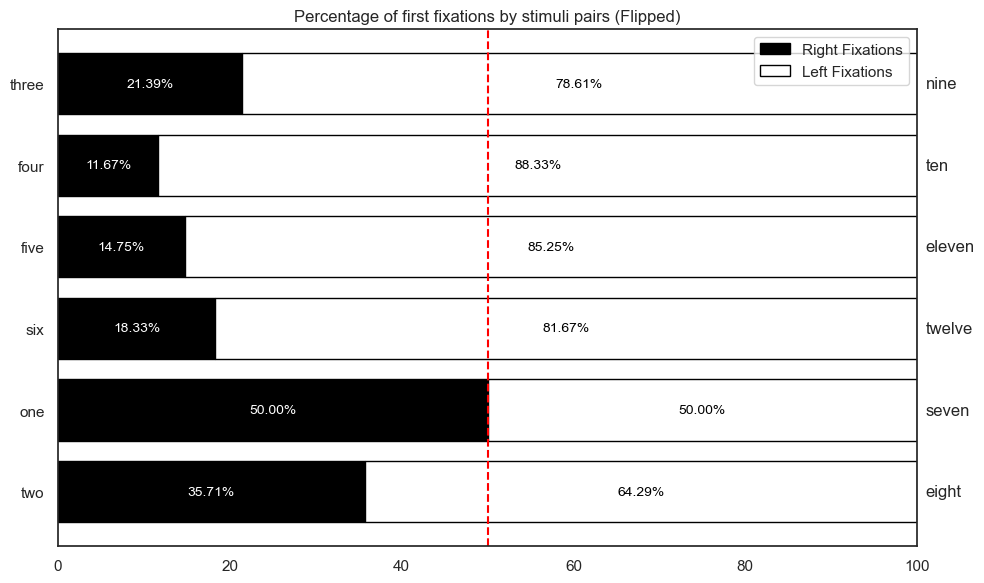

In [18]:
# Define the flipped pairs
pairs = [('three', 'nine'),('four', 'ten'), ('five', 'eleven'), ('six', 'twelve'), ('one', 'seven'), ('two', 'eight')]

# Prepare a summary count dataframe from tidy_df
sum_df = tidy_df['first_fixation'].value_counts().reset_index()
sum_df.columns = ['Coordinate', 'Count']

# Calculate the proportion of first fixations per pair
pair_sums = []
for coord1, coord2 in pairs:
    count1 = sum_df[sum_df['Coordinate'] == coord1]['Count'].values[0] if coord1 in sum_df['Coordinate'].values else 0
    count2 = sum_df[sum_df['Coordinate'] == coord2]['Count'].values[0] if coord2 in sum_df['Coordinate'].values else 0
    total = count1 + count2 if (count1 + count2) > 0 else 1  # Avoid division by zero
    pair_sums.append((coord1, coord2, count1 / total, count2 / total))

# Reverse the order for display
pair_sums = pair_sums[::-1]

# Extract plot components
left_description = [pair[0] for pair in pair_sums]
right_description = [pair[1] for pair in pair_sums]
left_fixations = [p[2] * 100 for p in pair_sums]
right_fixations = [p[3] * 100 for p in pair_sums]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.75
y = np.arange(len(left_description))

# Draw bars
ax.barh(y, left_fixations, color='black', height=bar_width, edgecolor='black', label='Right Fixations')
ax.barh(y, right_fixations, left=left_fixations, color='white', height=bar_width, edgecolor='black', label='Left Fixations')

# Add center line
ax.axvline(50, color='red', linestyle='--')

# Labeling
ax.set_yticks(y)
ax.set_yticklabels(left_description)
ax.set_title('Percentage of first fixations by stimuli pairs (Flipped)')
ax.legend()

# Add right-side labels
for i in range(len(y)):
    ax.text(101, y[i], right_description[i], va='center')

# Add internal percentage labels
for i in range(len(pair_sums)):
    ax.text(left_fixations[i] / 2, y[i], f'{left_fixations[i]:.2f}%', va='center', ha='center', fontsize=10, color='white')
    ax.text(left_fixations[i] + right_fixations[i] / 2, y[i], f'{right_fixations[i]:.2f}%', va='center', ha='center', fontsize=10, color='black')

# Adjust plot limits and layout
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()


/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_1970/1238363248.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(data=mean_choice_by_subject_condition,
/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_1970/1238363248.py:8: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=mean_choice_by_subject_condition,


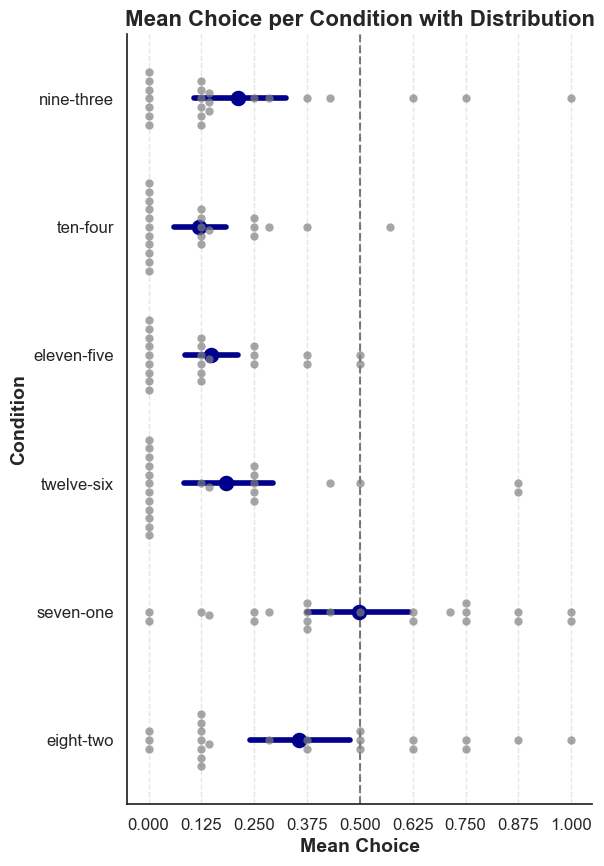

In [19]:
# Define the correct order for the conditions based on the dataframe
condition_order = ['nine-three', 'ten-four', 'eleven-five', 'twelve-six', 'seven-one', 'eight-two']

# Create the figure
plt.figure(figsize=(6, 10))

# Pointplot for mean values with confidence intervals
sns.pointplot(data=mean_choice_by_subject_condition, 
              y='condition', 
              x='mean_choice_by_condition', 
              order=condition_order, 
              estimator='mean', 
              ci=95,  # Bootstrapped 95% confidence interval
              color='darkblue', 
              markers='o', 
              scale=1.5, 
              linewidth=1.5, 
              linestyle="none")  # Remove line connecting points

# Swarmplot to show individual data points (flipped axes)
sns.swarmplot(data=mean_choice_by_subject_condition, 
              y='condition', 
              x='mean_choice_by_condition', 
              order=condition_order, 
              color='gray', 
              size=6, 
              alpha=0.7)

# Manuelles Anpassen der Marker-Ränder
for artist in plt.gca().collections:
    artist.set_edgecolor('black')

# Add dashed vertical line at 0.5
plt.axvline(x=0.5, linestyle='--', color='black', alpha=0.5)

# Customize the plot for scientific presentation
plt.ylabel('Condition', fontsize=14, fontweight='bold')
plt.xlabel('Mean Choice', fontsize=14, fontweight='bold')
plt.title('Mean Choice per Condition with Distribution', fontsize=16, fontweight='bold')
plt.xticks(np.arange(0.0, 1.125, 0.125), fontsize=12)  # Steps of 0.125
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine()

# Show the plot
plt.show()


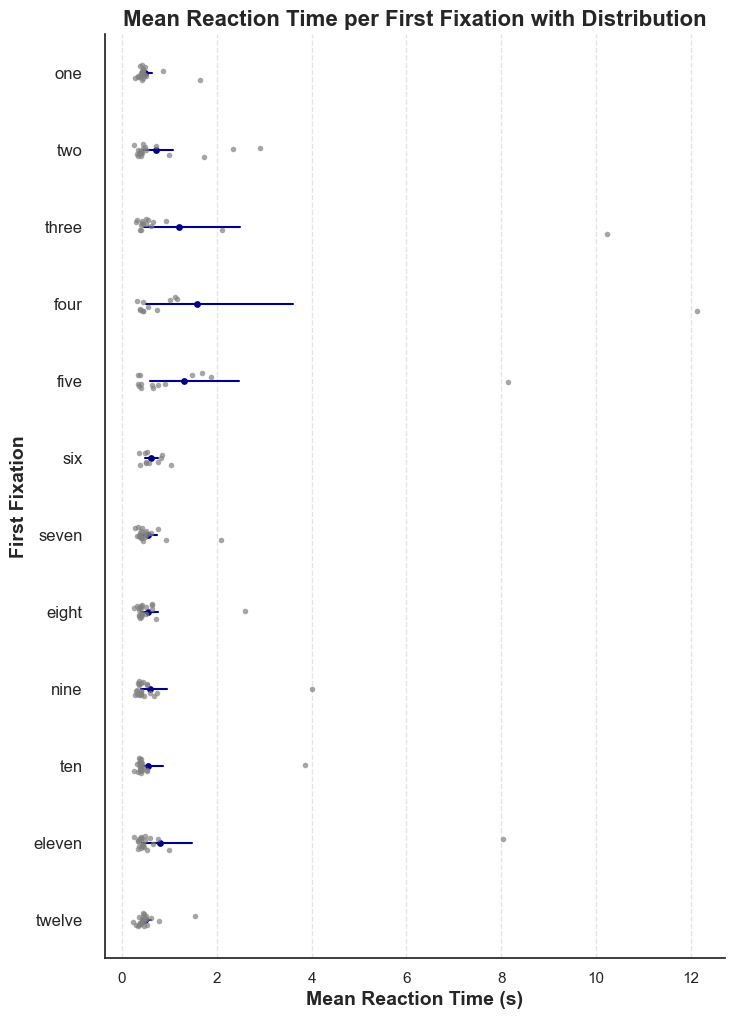

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure order matches first fixation values
fixation_order = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve']

plt.figure(figsize=(8, 12))  # Increase figure height

# Adjust y-axis ticks for better spacing
plt.gca().tick_params(axis='y', pad=10)  # Increase padding between labels and axis
plt.yticks(fontsize=14)  # Increase font size for better readability

# Pointplot for mean reaction time with confidence intervals
sns.pointplot(data=mean_time_by_fixation, 
              y='first_fixation', 
              x='mean_time_by_fixation', 
              order=fixation_order,  
              estimator='mean',  
              errorbar=('ci', 95),  # Updated parameter
              color='darkblue', 
              markers='o', 
              linewidth=1.5, 
              linestyle="none")

# Stripplot as an alternative to swarmplot
sns.stripplot(data=mean_time_by_fixation, 
              y='first_fixation', 
              x='mean_time_by_fixation', 
              order=fixation_order,  
              color='gray', 
              size=4,  # Decreased size
              alpha=0.7,
              jitter=True)  # Adds slight randomization

# Manually adjust marker edges
for artist in plt.gca().collections:
    artist.set_edgecolor('black')

# Customize the plot
plt.ylabel('First Fixation', fontsize=14, fontweight='bold')
plt.xlabel('Mean Reaction Time (s)', fontsize=14, fontweight='bold')
plt.title('Mean Reaction Time per First Fixation with Distribution', fontsize=16, fontweight='bold')

plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine()

# Show the plot
plt.show()


In [21]:
# Define the correct order for the conditions
condition_order = ['nine-three', 'ten-four', 'eleven-five', 'twelve-six', 'seven-one', 'eight-two']

# Function to calculate bootstrapped 95% CI in percent (flipped)
def compute_bootstrap_ci(data, seed=42):
    data = np.array(data)
    ci = bootstrap(
        (data,),
        np.mean,
        confidence_level=0.95,
        n_resamples=10000,
        method='percentile',
        random_state=seed
    ).confidence_interval
    return 100 - (ci.high * 100), 100 - (ci.low * 100)  # Flip the confidence interval

# Compute mean and CIs for each condition (flipping the values)
ci_results = {}
for condition in condition_order:
    subset = mean_choice_by_subject_condition[mean_choice_by_subject_condition['condition'] == condition]['mean_choice_by_condition']
    ci_low, ci_high = compute_bootstrap_ci(subset)
    ci_results[condition] = (ci_low, ci_high)

# Print CI values in flipped percent
print("95% Confidence Intervals:")
for condition, (ci_low, ci_high) in ci_results.items():
    print(f"{condition}: [{ci_low:.2f}%, {ci_high:.2f}%]")


95% Confidence Intervals:
nine-three: [67.08%, 88.28%]
ten-four: [81.68%, 93.40%]
eleven-five: [78.26%, 91.69%]
twelve-six: [70.65%, 91.61%]
seven-one: [38.04%, 62.34%]
eight-two: [52.02%, 75.93%]
